In [7]:
%matplotlib inline
import numpy as np
import cf
import matplotlib.pyplot as plt
import pysocibclient
import sys
sys.path.append("/home/ctroupin/Software/Python/seawater-3.3.2")
import seawater

In [8]:
gliderfile = 'http://thredds.socib.es/thredds/dodsC/auv/glider/ideep02-ime_sldeep002/L1/2015/dep0007_ideep02_ime-sldeep002_L1_2015-04-22_data_dt.nc'
gliderfile = 'http://thredds.socib.es/thredds/dodsC/auv/glider/ideep02-ime_sldeep002/L1/2015/dep0007_ideep02_ime-sldeep002_L1_2015-04-22_data_rt.nc'

In [9]:
# Compute density for T-S couples
# to add lines on the T-S diagram
density2plot = np.arange(24,30,.5)
smin, smax, tmin, tmax = 37.0, 38.75, 12., 21.
ds, dt = 0.05, 0.1
tvec = np.arange(tmin,tmax, dt)
svec = np.arange(smin,smax, ds)
ssvec, ttvec = np.meshgrid(svec, tvec)
density = seawater.eos80.dens0(ssvec,ttvec) - 1000.0

In [10]:
# Load data from the glider
f = cf.read(gliderfile)
tempGlider = f.select('sea_water_temperature')[0].array
psalGlider = f.select('sea_water_salinity')[0].array

# Filter out bad values
goodvalues = np.where(np.logical_and((tempGlider<35), (psalGlider< 45)) )
tempGlider = tempGlider[goodvalues]
psalGlider = psalGlider[goodvalues]

In [11]:
# Function that returns the list of opendap links for a given instrument
def create_deployement_list(instrument_type):
    socib_api = pysocibclient.ApiClient()
    alist = socib_api.list_platforms(instrument_type=instrument_type)

    mylist = []
    for deployment in alist:
        for productlist in deployment.product_list:
            if productlist.processing_level == "L1":
                mylist.append(productlist.opendap)
                #print productlist.opendap
    return mylist

instrument_type = 'CTD'
mylist = create_deployement_list(instrument_type)

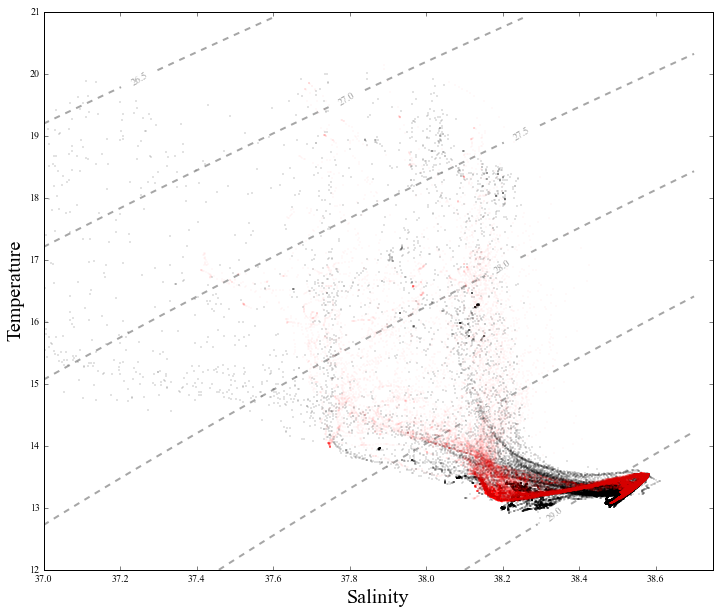

In [13]:
# Create the figure
fig=plt.figure(num=None, figsize=(12, 10))
ax = fig.add_subplot(111)

# Loop on the datafiles
for datafiles in mylist:
    f = cf.read(datafiles)
    temp = 0.5*(f.select('sea_water_temperature')[0].array + f.select('sea_water_temperature')[1].array)
    psal = 0.5*(f.select('sea_water_practical_salinity')[0].array + f.select('sea_water_practical_salinity')[1].array)
    plt.plot(psal, temp, 'k.', ms=0.5)

# Add temperature and salinity from the glider
plt.plot(psalGlider, tempGlider, 'ro', ms=0.5, markeredgecolor="None", zorder=3, alpha=0.5)

cont = plt.contour(svec, tvec, density, levels=density2plot, colors='.65', linestyles='dashed')
plt.clabel(cont,inline=True, fmt='%1.1f')
plt.xlim(smin, smax)
plt.ylim(tmin, tmax)
plt.xlabel('Salinity', fontsize=20)    
plt.ylabel('Temperature', fontsize=20)
plt.show()